# Computational Tests

This notebook is intended for running different kinds of analyses that would validate our reconstruction.

[1. Subsystem Overview and Analysis](#subsystems) <br>
[2. Context-specific model extraction with pymCADRE](#pymcadre) <br>
[3. Biomass prediction using exp. data](#biomass) <br>
[4. Flux Enrichment Analysis](#fea) <br>

## 1. Subsystem Overview and Analysis <a id='subsystems'></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from google_sheet import GoogleSheet

In [ ]:
##### ----- Generate Subsystems datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
SPREADSHEET_ID = '1MlBXeHIKw8k8fZyXm-sN__AHTRSunJxar_-bqvukZws'

# Initialize the GoogleSheet object
sheet = GoogleSheet(SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from the Google Sheet
sheet_subsystems = 'Summary Systems'
subsystems = sheet.read_google_sheet(sheet_subsystems)

In [ ]:
#### --- Pie Chart of the Amount of Reactions per System --- ####

subsystems["Number of Reactions"] = pd.to_numeric(subsystems["Number of Reactions"])

# Aggregate data by "System" and sum "Number of Reactions"
system_reactions = subsystems.groupby("System")["Number of Reactions"].sum()

# Set the figure and axes for more control
fig, ax = plt.subplots(figsize=(10, 7))

# Generate the pie chart again with the custom labels
patches, texts, autotexts = ax.pie(system_reactions, labels=system_reactions.index, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '', startangle=140, colors=plt.cm.tab20.colors)

# Improve aesthetics
for text in texts + autotexts:
    text.set_color('black')
ax.set_title("Pie Chart of Number of Reactions by System", pad=30)  # Move the title upwards by increasing pad

# Set equal aspect ratio
ax.axis('equal')

# Save the plot
plt.savefig('../Plots/pie_chart_reactions_per_system.png')

# Display the plot
plt.show()

In [ ]:
# Generate the Sunburst Plot
fig = px.sunburst(subsystems, path=['System', 'Subsystems','Kegg Pathway'],
                  color='System', title='System and Subsystems Relationship')

fig.update_layout(width=1200, height=1000)

fig.write_html("../Plots/sunburst_subsystems.html") # Save as interactive HTML file
fig.write_image("../Plots/sunburst_subsystems.png", width=1200, height=1000)
# Show the plot
fig.show()

#### Auxotrophies

In [ ]:
from cobra.io import load_json_model
iCHO_path = "iCHOv3_CHO_04032024.json"
iCHO = load_json_model(iCHO_path)

In [ ]:
amino_acids = {
    "arginine": ["EX_arg_L_e", "EX_arg_D_e"],
    "asparagine": ["EX_asn_L_e", "EX_asn_D_e"],
    "cysteine": ["EX_cys_L_e", "EX_cys_D_e", "EX_Lcystin_e"],
    "histidine": ["EX_his_L_e", "EX_his_D_e"],
    "isoleucine": ["EX_ile_L_e", "EX_ile_D_e"],
    "leucine": ["EX_leu_L_e", "EX_leu_D_e"],
    "lysine": ["EX_lys_L_e", "EX_lys_D_e"],
    "methionine": ["EX_met_L_e", "EX_met_D_e"],
    "phenylalanine": ["EX_phe_L_e", "EX_phe_D_e"],
    "proline": ["EX_pro_L_e", "EX_pro_D_e"],
    "threonine": ["EX_thr_L_e", "EX_thr_D_e"],
    "tryptophan": ["EX_trp_L_e", "EX_trp_D_e"],
    "valine": ["EX_val_L_e", "EX_val_D_e"]
}
for amino_acid in amino_acids:
    # ----- Setup initial bounds -----
    for exchange_reaction in iCHO.exchanges:
        exchange_reaction.bounds = -10, 10

    # Arginine
    iCHO.reactions.get_by_id('GAUGE-R00557').bounds = 0, 10
    iCHO.reactions.get_by_id('GAUGE-R10107').bounds = 0, 0
    iCHO.reactions.get_by_id('GAUGE-R00558').bounds = 0, 0
    iCHO.reactions.get_by_id('GLYAMDTRc').bounds = 0, 0
    iCHO.reactions.get_by_id('GAUGE-R10107').bounds = 0, 0
    iCHO.reactions.get_by_id('EX_valarggly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('ARGSL').bounds = 0, 0

    # Asparigine
    iCHO.reactions.get_by_id('ASNS1').bounds = 0, 0

    # Cysteine
    iCHO.reactions.get_by_id('r0129').bounds = 0, 0
    iCHO.reactions.get_by_id('EX_cgly_e').bounds = 0, 0
    iCHO.reactions.get_by_id('AMPTASECG').bounds = -10, 0
    iCHO.reactions.get_by_id('AMPTASECGe').bounds = -10, 0
    iCHO.reactions.get_by_id('CYSTGL').bounds = -10, 0
    iCHO.reactions.get_by_id('EX_HC00250_e').bounds = 0, 0
    iCHO.reactions.get_by_id('EX_sfcys_e').bounds = 0, 0

    # Histidine
    iCHO.reactions.get_by_id('VALTRPVALr').bounds = 0,0 

    # Isoleucine - DONE
    iCHO.reactions.get_by_id('EX_CE2916_e').bounds = 0,0 
    iCHO.reactions.get_by_id('EX_CE2915_e').bounds = 0,0 
    iCHO.reactions.get_by_id('ILETA').bounds = 0, 10
    iCHO.reactions.get_by_id('ILETAm').bounds = 0, 10

    # Leucine
    iCHO.reactions.get_by_id('LEULEULAPc').bounds = 0,0 
    iCHO.reactions.get_by_id('EX_leugly_e').bounds = 0,0 
    iCHO.reactions.get_by_id('EX_glyleu_e').bounds = 0,0 
    iCHO.reactions.get_by_id('LEUTA').bounds = 0, 10 
    iCHO.reactions.get_by_id('LEUTAm').bounds = 0, 10 
    iCHO.reactions.get_by_id('EX_CE5797_e').bounds = 0, 0

    # Lysine
    iCHO.reactions.get_by_id('EX_biocyt_e').bounds = 0,0 

    # Methionine
    iCHO.reactions.get_by_id('METS').bounds = -10, 0 
    iCHO.reactions.get_by_id('BHMT').bounds = -10, 0 
    iCHO.reactions.get_by_id('GAUGE-R00648').bounds = 0, 10 
    iCHO.reactions.get_by_id('UNK2').bounds = -10, 0 
    iCHO.reactions.get_by_id('UNK3').bounds = -10, 0 
    iCHO.reactions.get_by_id('TYRA').bounds = -10, 0 
    #iCHO.reactions.get_by_id('GAUGE-R06895').bounds = 0, 0 # Curated by MR with 1 score / Erased from the reconstruction

    # Phenylalanine
    iCHO.reactions.get_by_id('EX_CE5786_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_pheleu_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_glyphe_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE2917_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE5786_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE5789_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_phpyr_e').bounds = 0, 0 

    # Proline
    iCHO.reactions.get_by_id('EX_glypro_e').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_progly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('P5CR').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRxm').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRx').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRm').bounds = 0, 0
    iCHO.reactions.get_by_id('r1453').bounds = 0, 10

    # Threonine
    #iCHO.reactions.get_by_id('THRS').bounds = 0,0  # Erased from the reconstruction


    # Tryptophan
    iCHO.reactions.get_by_id('NBAHH_ir').bounds = 0,0  

    # Valine
    iCHO.reactions.get_by_id('EX_valarggly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_vallystyr_e').bounds = 0, 10
    iCHO.reactions.get_by_id('VALTA').bounds = 0, 10
    iCHO.reactions.get_by_id('VALTAm').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_valval_e').bounds = 0, 10
    # -----------------------------------------

    for exchange_reaction in iCHO.exchanges:
        if exchange_reaction.id in amino_acids[amino_acid]:
            exchange_reaction.bounds = 0, 10
            # print(amino_acid, exchange_reaction.id, amino_acids[amino_acid])
    sol = iCHO.optimize()
    print(amino_acid, sol.objective_value)


In [ ]:
amino_acids = {
    "alanine": ["EX_ala_B_e", "EX_ala_L_e", "EX_ala_D_e"],
    "arginine": ["EX_arg_L_e", "EX_arg_D_e"],
    "asparagine": ["EX_asn_L_e", "EX_asn_D_e"],
    "aspartic acid": ["EX_asp_L_e", "EX_asp_D_e"],
    "cysteine": ["EX_cys_L_e", "EX_cys_D_e"],
    "glutamine": ["EX_gln_L_e", "EX_gln_D_e"],
    "glutamic acid": ["EX_glu_L_e", "EX_glu_D_e"],
    "glycine": ["EX_gly_e"],
    "histidine": ["EX_his_L_e", "EX_his_D_e"],
    "isoleucine": ["EX_ile_L_e", "EX_ile_D_e"],
    "leucine": ["EX_leu_L_e", "EX_leu_D_e"],
    "lysine": ["EX_lys_L_e", "EX_lys_D_e"],
    "methionine": ["EX_met_L_e", "EX_met_D_e"],
    "phenylalanine": ["EX_phe_L_e", "EX_phe_D_e"],
    "proline": ["EX_pro_L_e", "EX_pro_D_e"],
    "serine": ["EX_ser_L_e", "EX_ser_D_e"],
    "threonine": ["EX_thr_L_e", "EX_thr_D_e"],
    "tryptophan": ["EX_trp_L_e", "EX_trp_D_e"],
    "tyrosine": ["EX_tyr_L_e", "EX_tyr_D_e"],
    "valine": ["EX_val_L_e", "EX_val_D_e"]
}

def test_auxotrophy(model, amino_acids):
    # Iterate through each amino acid and its corresponding exchange reactions
    for amino_acid, reactions in amino_acids.items():
        # Set the bounds for each exchange reaction
        for exchange in model.exchanges:
            if exchange.id in reactions:
                exchange.bounds = (0, 10)  # Allow secretion but not uptake
            else:
                exchange.bounds = (-10, 10)  # Allow uptake and secretion

        # Optimize the model for the current setup
        solution = model.optimize()
        if solution.status == "optimal":
            print(f"{amino_acid} biomass production: {solution.objective_value}")
        else:
            print(f"{amino_acid} optimization failed: {solution.status}")

In [ ]:
test_auxotrophy(iCHO, amino_acids)

In [ ]:
iCHO.metabolites.leu_L_c.summary()

#### Matrix Sparsity

#### Gene Deletion test

##### Essential for growth genes and comparison to (An optimised genome-wide, virus free CRISPR screen for mammalian cells)

##### Commparsion to other models

## 2. Context-specific model extraction with pymCADRE <a id='pymcadre'></a>

By using the python package pymCADRE we generate context-specific models to each one of the conditions from the dataset provided.

In [11]:
import pymCADRE
from pymCADRE.rank import *
from pymCADRE.prune import *

In [ ]:
# Steps:
# 1- RNA-seq data binarization
# 2- Calculate gene ubiquity scores

## 3. Biomass prediction using exp. data <a id='biomass'></a>

Here we incorporate uptake and secretion rates from (https://www.sciencedirect.com/science/article/pii/S2405471216303635?via%3Dihub) data and calculate the growth rate (Figure 3). Reproduce Hooman's analsys with iCHO_v1 and incorporate iCHO2291 and iCHO2441 into the analysis.

To do:
- Try ecFBA with enzyme trunover numbers.

In [1]:
# Load libraries
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import cobra
from cobra.io import load_json_model, read_sbml_model

In [2]:
# Define models

iCHO1766 = read_sbml_model('../Data/Reconciliation/models/iCHOv1_final.xml')
iCHO2291 = read_sbml_model('../Data/Reconciliation/models/iCHO2291.xml')
iCHO2441 = read_sbml_model('../Data/Reconciliation/models/iCHO2441.xml')
iCHO3000 = load_json_model('iCHOv3_CHO_15032024.json')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-04


In [3]:
# Preprocess and standarization of iCHO1766
iCHO1766.id = 'iCHO1766'
iCHO1766.reactions.biomass_cho_producing.id = 'biomass_cho_prod'
for r in iCHO1766.reactions:
    if r.id.endswith("_"):
        r.id = r.id[:-1]

# Preprocess and standarization of iCHO2101
iCHO2441.id = 'iCHO2441'
for r in iCHO2441.reactions:
    if r.id.endswith("(e)"):
        r.id = r.id.replace("(e)", "_e")
    if r.id == "SK_Asn_X_Ser/Thr[r]":
        r.id = "SK_Asn_X_Ser_Thr_r"
    if r.id == "SK_pre_prot[r]":
        r.id = "SK_pre_prot_r"
    if r.id == "SK_Ser/Thr[g]":
        r.id = "SK_Ser_Thr_g"
    if r.id == "SK_Tyr_ggn[c]":
        r.id = "SK_Tyr_ggn_c"
    if r.id == "DM_igg[g]":
        r.id = "DM_igg_g"

# Preprocess and standarization of iCHO2291
for r in iCHO2291.reactions:
    if r.id.endswith("(e)"):
        r.id = r.id.replace("(e)", "_e")
    if r.id == "SK_Asn_X_Ser/Thr[r]":
        r.id = "SK_Asn_X_Ser_Thr_r"
    if r.id == "SK_pre_prot[r]":
        r.id = "SK_pre_prot_r"
    if r.id == "SK_Ser/Thr[g]":
        r.id = "SK_Ser_Thr_g"
    if r.id == "SK_Tyr_ggn[c]":
        r.id = "SK_Tyr_ggn_c"
    if r.id == "DM_igg[g]":
        r.id = "DM_igg_g"

In [4]:
models = [iCHO1766, iCHO2291, iCHO2441, iCHO3000]

for model in models:
    model.reactions.biomass_cho.bounds = (0.0,10)
    model.reactions.biomass_cho_prod.bounds = (0.0,10)

In [5]:
uptsec = pd.read_excel('../Data/Uptake_Secretion_Rates/mmc4.xlsx', header=2)

biomass_bounds = uptsec[42:44]
biomass_bounds = biomass_bounds.set_index(['Reaction'])

uptsec = uptsec[:-5]

In [6]:
hp = uptsec.set_index('Reaction')['HP'].to_dict()
hp_nabu = uptsec.set_index('Reaction')['HP+NaBu'].to_dict()
lp = uptsec.set_index('Reaction')['LP'].to_dict()
lp_nabu = uptsec.set_index('Reaction')['LP+NaBu'].to_dict()
early_exp = uptsec.set_index('Reaction')['Early Exp'].to_dict()
late_exp = uptsec.set_index('Reaction')['Late Exp'].to_dict()
cold_1 = uptsec.set_index('Reaction')['Cold 1'].to_dict()
cold_2 = uptsec.set_index('Reaction')['Cold 2'].to_dict()

conditions = ['HP', 'HP+NaBu', 'LP', 'LP+NaBu', 'Early Exp', 'Late Exp', 'Cold 1', 'Cold 2']
dicts = [hp, hp_nabu, lp, lp_nabu, early_exp, late_exp, cold_1, cold_2]

In [7]:
for model in models:
    for rxn in model.boundary:
    
        # IMPORTANT, all ex should be 0 - 1000, except those that we know are being uptaken by the cell
        
        if rxn.id.startswith("EX_"):
            rxn.bounds = (0,1000) 
        if rxn.id.startswith("SK_"):
            rxn.bounds = (-1000,1000)
        if rxn.id.startswith("DM_"):
            rxn.bounds = (0,1000)

In [8]:
pfba_solutions_fluxes = []

df = pd.DataFrame(columns=["Model", "Condition", "Biomass_CHO", "Biomass_CHO_Prod"])

for model in models:

    model_data = []
    
    for cond,dic in zip(conditions,dicts):
        
        # Set lower bounds of the reactions according to the experimental data
        for reaction in model.reactions:
            for r,v in dic.items():
                if reaction.id == r:
                    if not pd.isna(v):
                        reaction.lower_bound = v
    
        # Calculate growth rate for each condition
        print('----------------------')
        print(f' Condtion: {cond} ')
        print('----------------------')

        # Print experimental growth rate
        exp_gr = biomass_bounds[cond]['Experimental growth rate']
        print(f'Experimental Growth Rate: {exp_gr}')

        # Calculate growth for biomass_cho
        model.objective = model.reactions.biomass_cho
        model.reactions.biomass_cho_prod.upper_bound = 0
        model.reactions.biomass_cho.upper_bound = 1000
        pfba_solution = cobra.flux_analysis.pfba(model)
        pfba_solution_biomass_cho = pfba_solution.fluxes['biomass_cho']
        print(f'Model: {model.id}, Biomass: {pfba_solution_biomass_cho}')

        # Calculate growth for biomass_cho_prod
        model.objective = model.reactions.biomass_cho_prod
        model.reactions.biomass_cho_prod.upper_bound = 1000
        model.reactions.biomass_cho.upper_bound = 0
        pfba_solution = cobra.flux_analysis.pfba(model)
        pfba_solution_biomass_cho_prod = pfba_solution.fluxes['biomass_cho_prod']
        print(f'Model: {model.id}, Biomass Prod: {pfba_solution_biomass_cho_prod}')
        print(' ')

        # Save the solution with metadata
        pfba_solutions_fluxes.append({
            "model_id": model.id,
            "condition": cond,
            "type": "biomass_cho_prod",
            "fluxes": pfba_solution.fluxes
        })

        # Append the results to the model_data list
        model_data.append({
            'Model': model.id,
            'Condition': cond,
            'Biomass_CHO': pfba_solution_biomass_cho,
            'Biomass_CHO_Prod': pfba_solution_biomass_cho_prod,
        })


    # Convert the model_data list to a DataFrame and concatenate it with the main DataFrame
    model_df = pd.DataFrame(model_data)
    df = pd.concat([df, model_df], ignore_index=True)


# Add the experimental growth rate values to the dataset
exp_data = []

for cond,dic in zip(conditions,dicts):
    exp_gr = biomass_bounds[cond]['Experimental growth rate']

    exp_data.append({
            'Model': "Exp",
            'Condition': cond,
            'Biomass_CHO': exp_gr,
            'Biomass_CHO_Prod': exp_gr,
        })
exp_df = pd.DataFrame(exp_data)
df = pd.concat([df, exp_df], ignore_index=True)

----------------------
 Condtion: HP 
----------------------
Experimental Growth Rate: 0.0306081099167615
Model: iCHO1766, Biomass: 0.027342941669092555
Model: iCHO1766, Biomass Prod: 0.021628908500716706
 
----------------------
 Condtion: HP+NaBu 
----------------------
Experimental Growth Rate: 0.0241918012900543
Model: iCHO1766, Biomass: 0.025522248264491166
Model: iCHO1766, Biomass Prod: 0.020188697111175748
 
----------------------
 Condtion: LP 
----------------------
Experimental Growth Rate: 0.0384006624306303
Model: iCHO1766, Biomass: 0.0183397174550775
Model: iCHO1766, Biomass Prod: 0.014507146870329779
 
----------------------
 Condtion: LP+NaBu 
----------------------
Experimental Growth Rate: 0.0282505808359962
Model: iCHO1766, Biomass: 0.03623027621901623
Model: iCHO1766, Biomass Prod: 0.028658998619048883
 
----------------------
 Condtion: Early Exp 
----------------------
Experimental Growth Rate: 0.0247465437788018
Model: iCHO1766, Biomass: 0.028913778307605453
Model

/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_4272/923247499.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, model_df], ignore_index=True)


Model: iCHO2291, Biomass: 0.027342976020407923
Model: iCHO2291, Biomass Prod: 0.02162890042383863
 
----------------------
 Condtion: HP+NaBu 
----------------------
Experimental Growth Rate: 0.0241918012900543
Model: iCHO2291, Biomass: 0.025522370814573238
Model: iCHO2291, Biomass Prod: 0.020188764996053602
 
----------------------
 Condtion: LP 
----------------------
Experimental Growth Rate: 0.0384006624306303
Model: iCHO2291, Biomass: 0.018339708908976425
Model: iCHO2291, Biomass Prod: 0.014507148532983368
 
----------------------
 Condtion: LP+NaBu 
----------------------
Experimental Growth Rate: 0.0282505808359962
Model: iCHO2291, Biomass: 0.03623021179963273
Model: iCHO2291, Biomass Prod: 0.028659055439502916
 
----------------------
 Condtion: Early Exp 
----------------------
Experimental Growth Rate: 0.0247465437788018
Model: iCHO2291, Biomass: 0.02891372689734952
Model: iCHO2291, Biomass Prod: 0.022871522438137844
 
----------------------
 Condtion: Late Exp 
-------------

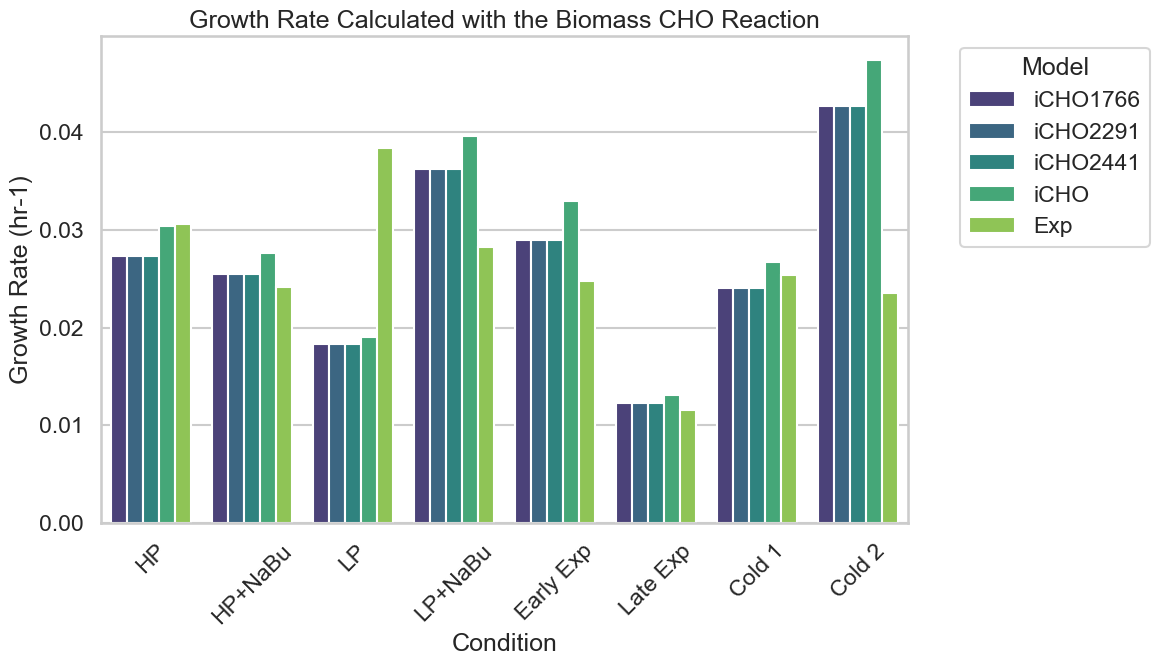

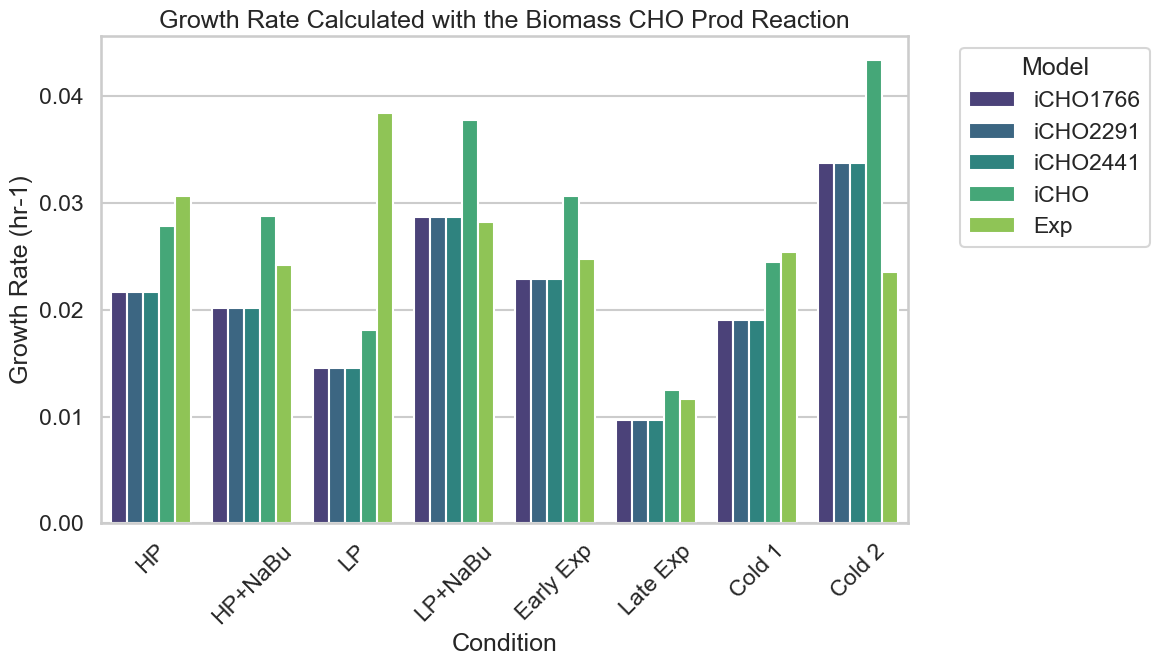

In [9]:
sns.set_style("whitegrid")
sns.set_context("talk") 

# Plotting for Biomass_CHO
plt.figure(figsize=(12, 7))
barplot_cho = sns.barplot(data=df, x="Condition", y="Biomass_CHO", hue="Model", palette="viridis")
plt.title("Growth Rate Calculated with the Biomass CHO Reaction")
plt.ylabel("Growth Rate (hr-1)")
plt.xlabel("Condition")
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../Plots/bar_plot_growth_rate_biomass_cho.png')
plt.show()

# Plotting for Biomass_CHO_Prod
plt.figure(figsize=(12, 7))
barplot_cho_prod = sns.barplot(data=df, x="Condition", y="Biomass_CHO_Prod", hue="Model", palette="viridis")
plt.title("Growth Rate Calculated with the Biomass CHO Prod Reaction")
plt.ylabel("Growth Rate (hr-1)")
plt.xlabel("Condition")
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../Plots/bar_plot_growth_rate_biomass_cho_prod.png')
plt.show()

## 4. Flux Enrichment Analysis <a id='fea'></a>

In [1]:
# OPTION 1
# Use the fluxes from the growth rate calculations to filter reactions with fluxes
# Define a cut off for the flux ??? # Plot to visualization of the flux distribution
# Run Flux Enrichment Analysis on those reactions to see pathways enriched when optimized by biomass

In [2]:
# OPTION 2
# Transcriptomic data from cell batches / biorreactiors
# Overlay this into the recons and extract the reactions associated to the genes
# Extract a reaction vector / 
# Run Flux Enrichment Analysis

In [4]:
# R1 = g1 or (g2 and G3)
# r1 = max(r1, (min(g2, g3))
# r1 = sum(r1, min(g2, g3))
# GIMME 
# Use mCADRE

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

def flux_enrichment_analysis(model, rxn_indices, attribute='subsystem'):
    # Ensure rxn_indices is a list of integers
    if not isinstance(rxn_indices, list) or not all(isinstance(i, int) for i in rxn_indices):
        raise ValueError('rxn_indices must be a list of integers')
    
    # Check if the attribute exists in the first reaction as a proxy for all
    if not hasattr(model.reactions[0], attribute):
        raise ValueError(f'Attribute {attribute} not found in model reactions')

    # Extract attribute information for all reactions
    attribute_values = [getattr(rxn, attribute, 'None') for rxn in model.reactions]
    unique_attributes = set(attribute_values)
    
    # Count occurrences in the model and in the reaction set
    model_counts = {attr: attribute_values.count(attr) for attr in unique_attributes}
    rxn_set_counts = {attr: 0 for attr in unique_attributes}
    for idx in rxn_indices:
        rxn_attr = getattr(model.reactions[idx], attribute, 'None')
        rxn_set_counts[rxn_attr] += 1

    # Calculate p-values using hypergeometric test
    M = len(model.reactions)  # Total number of reactions
    n = len(rxn_indices)  # Size of reaction set
    p_values = []
    for attr in unique_attributes:
        N = model_counts[attr]  # Total reactions in group
        x = rxn_set_counts[attr]  # Reactions in group and in set
        p_value = hypergeom.sf(x-1, M, N, n)
        p_values.append(p_value)

    # Adjust p-values for multiple testing
    _, adj_p_values, _, _ = multipletests(p_values, method='fdr_bh')

    # Compile results
    results = pd.DataFrame({
        'Group': list(unique_attributes),
        'P-value': p_values,
        'Adjusted P-value': adj_p_values,
        'Enriched set size': [rxn_set_counts[attr] for attr in unique_attributes],
        'Total set size': [model_counts[attr] for attr in unique_attributes],
    }).sort_values(by='Adjusted P-value')

    return results

In [ ]:
from cobra.io import load_json_model
iCHO3000 = load_json_model('iCHOv3_CHO_05032024.json')

### Test 1: FEA on reactions active during growth rate optimization
Use the fluxes from the growth rate calculations to filter reactions with fluxes

In [30]:
# Generate a vector of active reactions for each one of the conditions

active_reactions = []

for sol in pfba_solutions_fluxes:
    if sol['model_id'] == 'iCHO':
        rxns_fluxes = []
        for i,(r,f) in enumerate(sol['fluxes'].items()):
            if f != 0:
                rxns_fluxes.append(i)
        
        active_reactions.append({
            "model_id": sol['model_id'],
            "condition": sol['condition'],
            "flux_vector": rxns_fluxes
        })


In [62]:
# Generate FEA results for each one of the vectors generated for each condition

fea_results = []

for fluxes in active_reactions:
    results = flux_enrichment_analysis(iCHO3000, fluxes['flux_vector'], 'subsystem')
    fea_results.append({
        "Condition": fluxes['condition'],
        "Results": results
    })

In [67]:
# Transform p-values to -log10

all_data = pd.DataFrame()

for result in fea_results:
    condition = result['Condition']
    temp_df = result['Results'][['Group', 'P-value']].copy()
    temp_df.columns = ['Group', f'P-value_{condition}']
    if all_data.empty:
        all_data = temp_df
    else:
        all_data = pd.merge(all_data, temp_df, on='Group', how='outer')

# Remove groups with a 0 value in all conditions (assuming a '0' value indicates non-significance)
significant_filter = (all_data.drop(columns='Group') < 0.05).any(axis=1)
filtered_data = all_data[significant_filter]
filtered_data.reset_index(inplace=True, drop=True)

# Transform the p-values
for col in filtered_data.columns:
    if col.startswith('P-value'):
        filtered_data[f'-log10({col})'] = -np.log10(filtered_data[col])

/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_4272/1054406137.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[f'-log10({col})'] = -np.log10(filtered_data[col])
/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_4272/1054406137.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[f'-log10({col})'] = -np.log10(filtered_data[col])
/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_4272/1054406137.py:22: SettingWithCopyWarning: 
A value is trying to 

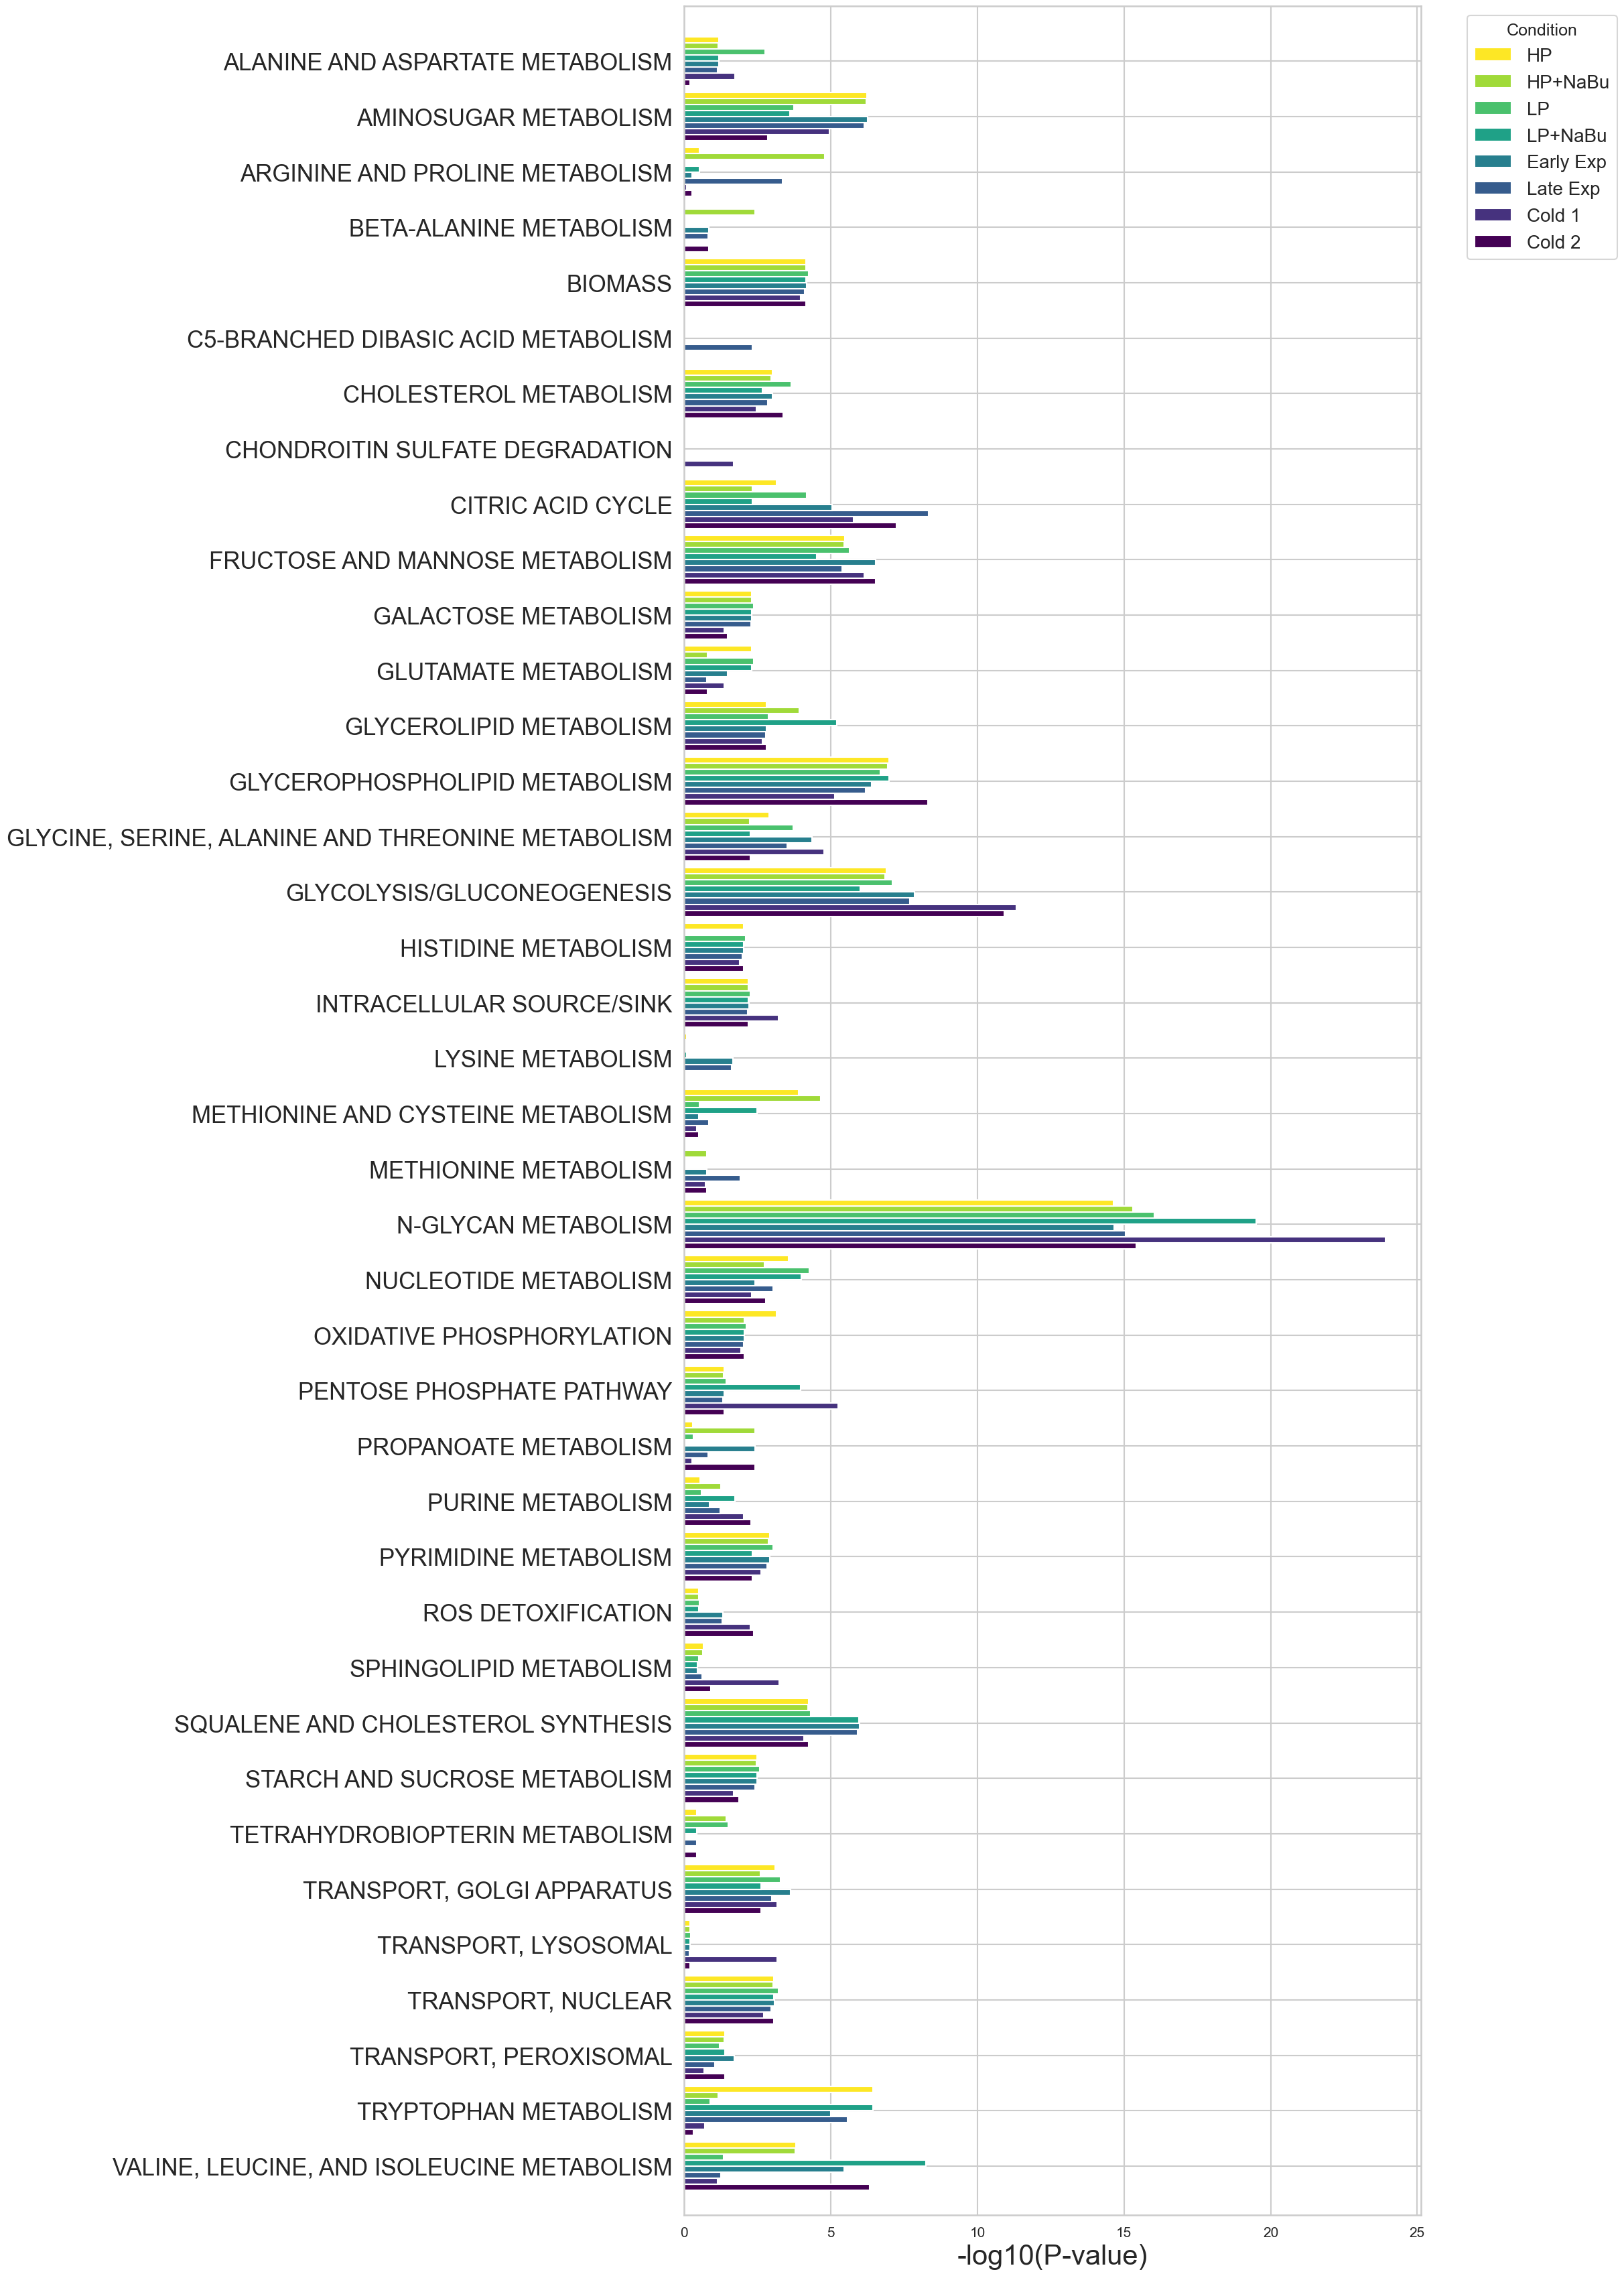

In [70]:
# Invert the data for plotting the yticks correctly
filtered_data = filtered_data.iloc[::-1].reset_index(drop=True)

# Adjusting the bar width and spacing
bar_width = 0.11  # Decrease the bar width for more distinct separation
spacing = 0  # Increase the spacing between bars of different conditions

# Assuming 'filtered_data' is structured with 'Group' and transformed p-value columns
# Example conditions derived from your DataFrame's columns
conditions = [col.replace('-log10(P-value_', '').replace(')', '') for col in filtered_data if col.startswith('-log10')]
conditions = conditions[::-1]

# Define colors for each condition using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(conditions)))

# Figure setup
fig_height = len(filtered_data['Group']) * (bar_width + spacing) * len(conditions)
plt.figure(figsize=(25, fig_height))

# Initial y positions for each group's first condition bar
initial_pos = np.arange(len(filtered_data['Group']))

# Plotting
for i, condition in enumerate(conditions):
    position = [p + (bar_width + spacing) * i for p in initial_pos]
    plt.barh(position, filtered_data[f'-log10(P-value_{condition})'], height=bar_width, color=colors[i], label=condition)

plt.tick_params(axis='y', labelsize=25)
plt.tick_params(axis='x', labelsize=15)
plt.yticks(initial_pos + (bar_width + spacing) * (len(conditions) - 1) / 2, filtered_data['Group'])
plt.xlabel('-log10(P-value)', fontsize=30)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), fontsize=20, loc='upper left', reverse=True)

# Manually adjust the y-axis limits if necessary
plt.ylim(-0.5, len(filtered_data['Group']) - 0.5 + (bar_width + spacing) * len(conditions))

plt.tight_layout()

plt.savefig('../Plots/FEA_biomass_prod_iCHO3000.png', format='png', dpi=300, bbox_inches='tight')
plt.show()